<a href="https://colab.research.google.com/github/delibae/AI_study/blob/main/CNN_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inception Fine Tuning

## load inception v3

In [1]:
from tensorflow.keras import applications

from tensorflow.keras import layers
import tensorflow as tf

In [15]:
# with tf.device('/device:GPU:0'):

base_model = applications.inception_v3.InceptionV3(include_top = False,  weights='imagenet', input_shape=(75,75,3))

In [ ]:
base_model.summary()

In [ ]:
base_model.output
base_model.input


base_model.summary()

## data preprocessing

In [16]:
# 데이터 경로 설정
folder_path = '/content/drive/MyDrive/AI_3/real_data_test database'

# 데이터 불러오기.
import glob
import PIL
import numpy as np
from sklearn.model_selection import train_test_split

# 남자, 승기 구분 프로그램을 위한 폴더이름 적어놓기.
folders = ['man', 'seunggi']

# 리스트 하나 만들어놔야지.
x_data = []
y_data = []
label = 0

# 각각의 개체 files에 저장.
for folder in folders:
  files = glob.glob(folder_path + '/' + folder + '/*')
# 파일 이름들에 대해 열어서,
  for file_path in files:
    img = PIL.Image.open(file_path)
    img = img.convert('RGB')  # 흑백 사진도 처리 가능하게 rgb 단위로. + pixel 64 * 64
    img = img.resize((75, 75))
    np_image = np.array(img)
    x_data.append(np_image) # 승기든 남자든 numpy 행렬 데이터 넣자.
    y_data.append(label) # label (구분기준) 넣어놓자.
  label += 1 # 승기 다 끝나고, 남자 구분기준으로 바꾸는 작업.

x_data = np.array(x_data)
y_data = np.array(y_data)

print(x_data.shape)
print(y_data.shape)

# 20퍼만 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
x_train, x_test = x_train/255, x_test/255

(187, 75, 75, 3)
(187,)


## train

Epoch 1/10
2/2 [==============================] - 22s 4s/step - loss: 0.7246 - accuracy: 0.6174 - val_loss: 1.0351 - val_accuracy: 0.7368
Epoch 2/10
2/2 [==============================] - 0s 175ms/step - loss: 0.6910 - accuracy: 0.7651 - val_loss: 0.7328 - val_accuracy: 0.7105
Epoch 3/10
2/2 [==============================] - 0s 129ms/step - loss: 0.5242 - accuracy: 0.8456 - val_loss: 10.1041 - val_accuracy: 0.3158
Epoch 4/10
2/2 [==============================] - 0s 166ms/step - loss: 0.3630 - accuracy: 0.9060 - val_loss: 4.5292 - val_accuracy: 0.5263
Epoch 5/10
2/2 [==============================] - 0s 161ms/step - loss: 0.2340 - accuracy: 0.8792 - val_loss: 15.4846 - val_accuracy: 0.6579
Epoch 6/10
2/2 [==============================] - 0s 158ms/step - loss: 0.1951 - accuracy: 0.9463 - val_loss: 26.2976 - val_accuracy: 0.6579
Epoch 7/10
2/2 [==============================] - 0s 139ms/step - loss: 0.1194 - accuracy: 0.9799 - val_loss: 34.9261 - val_accuracy: 0.6579
Epoch 8/10
2/2 [==

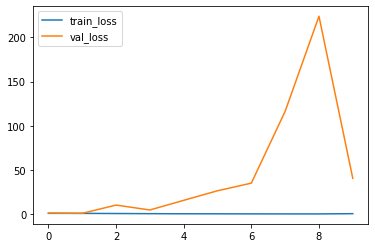

In [4]:
with tf.device('/device:GPU:0'):
  flat_layer = layers.Flatten()(base_model.output)
  output = layers.Dense(2, activation = 'softmax')(flat_layer)

  model = tf.keras.models.Model(base_model.input, output)
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  # batch size 가 커질수록, 연산(이 case에서는 200000개의 parameter) 후 가져오는 parameter의 개수 = batch size기 때문에, 메모리에서 그 parameter를 가져오는 과정에서 메모리가 터질 수 있음. (batch size가 클수록.)
  history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 100)

import matplotlib
# 학습하면 학습할수록, train_loss는 감소, 하지만, val_loss 는 다시 증가(overfitting 발생)
matplotlib.pyplot.plot(history.history['loss'], label = 'train_loss')
matplotlib.pyplot.plot(history.history['val_loss'], label = 'val_loss')
matplotlib.pyplot.legend()

## fine tuning 하는 팁

전체 freeze (Feature Extract Model Freze) -> FCL 학습  

경우1. 우리의 테이터셋이 pretrained 모델의 category가 유사하다면 , 50% FE모델만 학습  

경우2. 우리의 데이터셋이, pretrained 모델의 category가 유사 하지 않다면, 데이터 수가 부족하다면 전체 FE 모델 학습

## 전체 Freeze

In [17]:
base_model.trainable = False

In [49]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

Epoch 1/30
2/2 [==============================] - 5s 1s/step - loss: 0.9212 - accuracy: 0.4698 - val_loss: 0.7430 - val_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - 0s 84ms/step - loss: 0.7448 - accuracy: 0.5772 - val_loss: 0.6301 - val_accuracy: 0.5789
Epoch 3/30
2/2 [==============================] - 0s 91ms/step - loss: 0.6201 - accuracy: 0.6779 - val_loss: 0.6243 - val_accuracy: 0.6316
Epoch 4/30
2/2 [==============================] - 0s 67ms/step - loss: 0.5272 - accuracy: 0.7383 - val_loss: 0.6548 - val_accuracy: 0.6316
Epoch 5/30
2/2 [==============================] - 0s 65ms/step - loss: 0.4596 - accuracy: 0.7919 - val_loss: 0.6292 - val_accuracy: 0.6316
Epoch 6/30
2/2 [==============================] - 0s 63ms/step - loss: 0.4079 - accuracy: 0.8389 - val_loss: 0.5826 - val_accuracy: 0.6579
Epoch 7/30
2/2 [==============================] - 0s 57ms/step - loss: 0.3606 - accuracy: 0.8591 - val_loss: 0.5356 - val_accuracy: 0.6579
Epoch 8/30
2/2 [=============

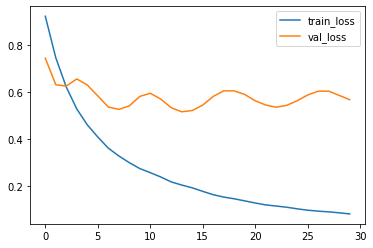

In [18]:
with tf.device('/device:GPU:0'):
  flat_layer = layers.Flatten()(base_model.output)
  output = layers.Dense(2, activation = 'softmax')(flat_layer)

  model = tf.keras.models.Model(base_model.input, output)
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  # batch size 가 커질수록, 연산(이 case에서는 200000개의 parameter) 후 가져오는 parameter의 개수 = batch size기 때문에, 메모리에서 그 parameter를 가져오는 과정에서 메모리가 터질 수 있음. (batch size가 클수록.)
  history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 30, batch_size = 100)

import matplotlib
# 학습하면 학습할수록, train_loss는 감소, 하지만, val_loss 는 다시 증가(overfitting 발생)
matplotlib.pyplot.plot(history.history['loss'], label = 'train_loss')
matplotlib.pyplot.plot(history.history['val_loss'], label = 'val_loss')
matplotlib.pyplot.legend()

## 경우1

In [57]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

In [19]:
for layer in base_model.layers[:155]:
  layer.trainable = True


In [59]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

In [20]:
custom_adam = tf.keras.optimizers.Adam(learning_rate = 0.00001)

Epoch 32/60
2/2 [==============================] - 6s 1s/step - loss: 0.7535 - accuracy: 0.4765 - val_loss: 1.3679 - val_accuracy: 0.3947
Epoch 33/60
2/2 [==============================] - 0s 107ms/step - loss: 0.4767 - accuracy: 0.8591 - val_loss: 1.2569 - val_accuracy: 0.3684
Epoch 34/60
2/2 [==============================] - 0s 95ms/step - loss: 0.3266 - accuracy: 0.9664 - val_loss: 1.1825 - val_accuracy: 0.3947
Epoch 35/60
2/2 [==============================] - 0s 97ms/step - loss: 0.2454 - accuracy: 0.9933 - val_loss: 1.1278 - val_accuracy: 0.3947
Epoch 36/60
2/2 [==============================] - 0s 97ms/step - loss: 0.1959 - accuracy: 0.9933 - val_loss: 1.0739 - val_accuracy: 0.4474
Epoch 37/60
2/2 [==============================] - 0s 99ms/step - loss: 0.1513 - accuracy: 0.9933 - val_loss: 1.0424 - val_accuracy: 0.4211
Epoch 38/60
2/2 [==============================] - 0s 98ms/step - loss: 0.1253 - accuracy: 1.0000 - val_loss: 1.0186 - val_accuracy: 0.3947
Epoch 39/60
2/2 [====

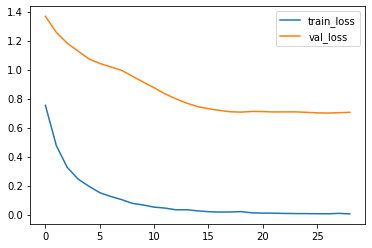

In [21]:

with tf.device('/device:GPU:0'):
  flat_layer = layers.Flatten()(base_model.output)
  output = layers.Dense(2, activation = 'softmax')(flat_layer)
  model = tf.keras.models.Model(base_model.input, output)
  model.compile(optimizer = custom_adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  history = model.fit(x_train, y_train, validation_data = (x_test, y_test), initial_epoch = 31, epochs = 60, batch_size = 100)

import matplotlib
# 학습하면 학습할수록, train_loss는 감소, 하지만, val_loss 는 다시 증가(overfitting 발생)
matplotlib.pyplot.plot(history.history['loss'], label = 'train_loss')
matplotlib.pyplot.plot(history.history['val_loss'], label = 'val_loss')
matplotlib.pyplot.legend()

In [22]:
model.save('/content/drive/MyDrive/AI_3/mymodel')